In [1]:
try:
    !pip install scikit-learn matplotlib catboost seaborn --quiet
except Exception as e:
    print(f"An error occurred: {e}")

In [2]:
import pandas as pd
import numpy as np
import seaborn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MaxAbsScaler
from sklearn.utils.extmath import softmax

In [3]:
train = pd.read_csv('../Data/train_preprocessed.csv')
test = pd.read_csv('../Data/test_preprocessed.csv')

In [4]:
def feature_importances(df):
    df = pd.get_dummies(data=df, columns=['HomePlanet', 'Cabin'], drop_first=True)

    # Определяем X и y
    X = df.drop('Transported', axis=1)
    y = df['Transported']

    le_transported = LabelEncoder()
    y = le_transported.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

    # Логистическая регрессия
    clf_lr = LogisticRegression(random_state=0, max_iter=1000)
    clf_lr.fit(X_train, y_train)
    coef_lr = clf_lr.coef_[0]

    acc_train_lr = accuracy_score(y_true=y_train, y_pred=clf_lr.predict(X_train))
    acc_test_lr = accuracy_score(y_true=y_test, y_pred=clf_lr.predict(X_test))
    label_lr = f'Importance (LR abs), acc_train = {acc_train_lr:.2%}, acc_test = {acc_test_lr:.2%}'

    # Random Forest
    clf_rf = RandomForestClassifier(random_state=0)
    clf_rf.fit(X_train, y_train)
    coef_rf = clf_rf.feature_importances_

    acc_train_rf = accuracy_score(y_true=y_train, y_pred=clf_rf.predict(X_train))
    acc_test_rf = accuracy_score(y_true=y_test, y_pred=clf_rf.predict(X_test))
    label_rf = f'Importance (RF), acc_train = {acc_train_rf:.2%}, acc_test = {acc_test_rf:.2%}'

    # CatBoost
    clf_cat = CatBoostClassifier(random_state=0, silent=True)
    clf_cat.fit(X_train, y_train)
    coef_cat = clf_cat.feature_importances_

    acc_train_cat = accuracy_score(y_true=y_train, y_pred=clf_cat.predict(X_train).astype('bool'))
    acc_test_cat = accuracy_score(y_true=y_test, y_pred=clf_cat.predict(X_test).astype('bool'))
    label_cat = f'Importance (CatBoost), acc_train = {acc_train_cat:.2%}, acc_test = {acc_test_cat:.2%}'

    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'LR': np.abs(coef_lr),
        'RF': coef_rf,
        'CatBoost': coef_cat
    })

    # Суммируем важность по исходным категориальным переменным
    feature_importances['Category'] = feature_importances['Feature'].str.split('_').str[0]
    grouped_importances = feature_importances.groupby('Category').sum().reset_index()

    # Сортируем по важности
    grouped_importances = grouped_importances.sort_values(by='CatBoost', ascending=False)

    # Масштабируем важность
    scaler = MaxAbsScaler()
    grouped_importances[['LR', 'RF', 'CatBoost']] = scaler.fit_transform(grouped_importances[['LR', 'RF', 'CatBoost']])

    grouped_importances.plot(kind='bar', x='Category', figsize=(10, 6))
    plt.title('Feature Importance by Category')
    plt.ylabel('Normalized Importance')
    plt.show()
    return ([acc_train_lr, acc_train_rf, acc_train_cat], [acc_test_lr, acc_test_rf, acc_test_cat])

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_1587/954386848.py:59: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_importances = feature_importances.groupby('Category').sum().reset_index()


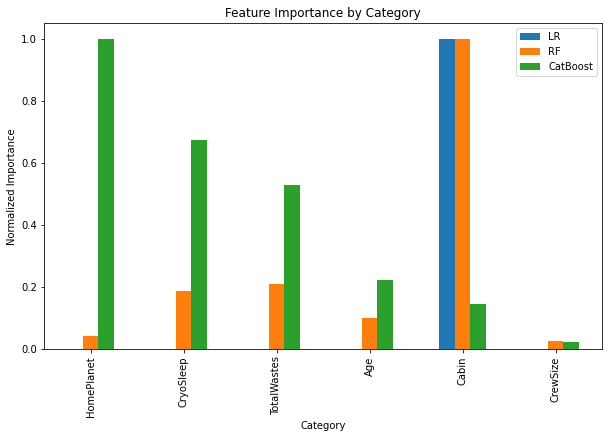

In [6]:
train2 = train[['CryoSleep', 'Age', 'TotalWastes', 'CrewSize', 'Transported', 'HomePlanet', 'Cabin']]
acc_train, acc_test = feature_importances(train2)

<Axes: >

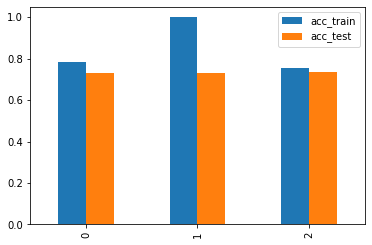

In [7]:
d = {
    'acc_train': acc_train,
    'acc_test': acc_test
}

acc_df = pd.DataFrame(d)
acc_df.plot.bar()